In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

%matplotlib inline
# sns.set(style='ticks', palette='Set2')
plt.rcParams['figure.figsize'] = 15, 12

import warnings
warnings.filterwarnings('ignore')


In [2]:
train_df = pd.read_csv( "data/train_mail.tsv", sep='\t' )
train_df.head()

STATE DOMAIN   AGE HOMEOWNR  NUMCHLD  INCOME GENDER  WEALTH1  HIT  MBCRAFT  \
0    AL     T2   NaN        H      NaN     5.0      F      NaN  0.0      NaN   
1    CA         79.0               NaN     NaN      F      NaN  0.0      NaN   
2    FL     S1  86.0        H      NaN     7.0      M      9.0  1.0      0.0   
3    MO     T2  25.0        U      NaN     1.0      M      4.0  0.0      NaN   
4    CA     U2  69.0        U      NaN     3.0      F      3.0  5.0      0.0   

     ...     PUBHLTH  PUBDOITY  PUBNEWFN  PUBPHOTO  PUBOPP  MAJOR  PEPSTRFL  \
0    ...         NaN       NaN       NaN       NaN     NaN                X   
1    ...         NaN       NaN       NaN       NaN     NaN                X   
2    ...         0.0       0.0       0.0       0.0     0.0                X   
3    ...         NaN       NaN       NaN       NaN     NaN                    
4    ...         2.0       0.0       0.0       0.0     0.0                X   

   NUMPRM12  NGIFTALL  TARGET_B  
0      12.0       6.0         0  
1      28.0      20.0         0  
2      14.0      37.0         0  
3       7.0       6.0         0  
4      22.0      11.0         0  

[5 rows x 28 columns]

### Let's get a sense of the missing values

**Question:** How many instances (rows) have _at least one_ missing value?

**Question:** How are the missing values distributed among the features themselves?


In [3]:
# The following line will return how many null values (i.e. how man rows) we have for each feature

train_df.isnull().sum()

STATE           0
DOMAIN          0
AGE          4449
HOMEOWNR        0
NUMCHLD     15834
INCOME       4041
GENDER          0
WEALTH1      8505
HIT             0
MBCRAFT     10031
MBGARDEN    10031
MBBOOKS     10031
MBCOLECT    10037
MAGFAML     10031
MAGFEM      10031
MAGMALE     10031
PUBGARDN    10031
PUBCULIN    10031
PUBHLTH     10031
PUBDOITY    10031
PUBNEWFN    10031
PUBPHOTO    10031
PUBOPP      10031
MAJOR           0
PEPSTRFL        0
NUMPRM12        0
NGIFTALL        0
TARGET_B        0
dtype: int64

### Missing values for each case here

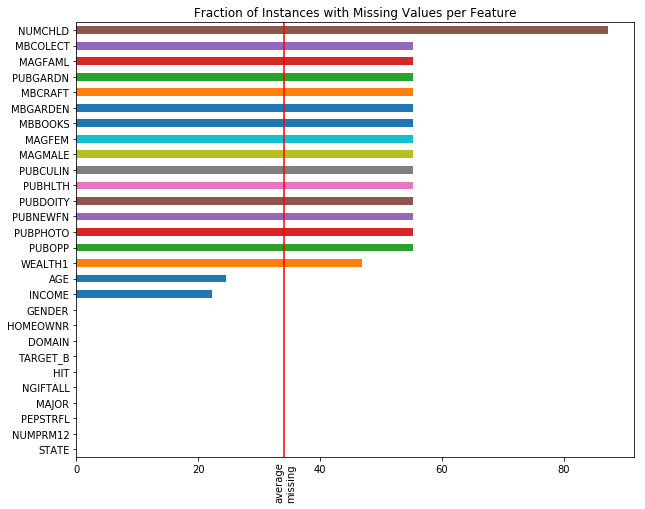

In [4]:
empty_fractions = 100.0 * (train_df.isnull().sum() / len(train_df))
empty_fractions.sort_values(ascending=True).plot(kind="barh", figsize=(10,8))

average_overall = empty_fractions.mean()
plt.axvline(x=average_overall, color='red')  # Plots a vertical line at x = <value>
plt.text(average_overall - 1.5, -2, 'average\nmissing', rotation=90)  # Set the text for the tick

plt.title("Fraction of Instances with Missing Values per Feature")
plt.show()

### Approach 1: Drop the instances

This approach is also commonly known as _listwise deletion_. We **remove** an instance _entirely_ if it contains even a single missing value.

Despite some statistical advantages under certain assumptions* (e.g., avoiding bias), listwise deletion reduces the effective sample size of the population, since we are removing entire instances from the population. This may also detract from the predictive power of our models, and their ability to generalize.


*Interestinly enough, these assumptions rarely hold in practice.

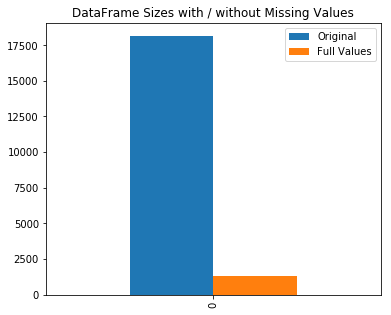

In [5]:
df_comp = pd.DataFrame( [[len(train_df), len(train_df.dropna(axis=0))]], columns=['Original', 'Full Values'] ) 
df_comp.plot.bar(width=0.5, figsize=(6,5), title="DataFrame Sizes with / without Missing Values")
plt.show()

#### What if we only drop the top 5

_Note:_ The number 5 is arbitrarily chosen here. 

See the documentation here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [6]:
df_copy = train_df.copy()

dfSizes = [ len(train_df) ]  # The original dataframe size
columnNames = [ 'Original' ]

# Iterate over the top-5 features with the most missing values and drop any row that contains them
for featName in empty_fractions.sort_values(ascending=False).head().index:

    # The subset parameter allows us to check in specific features
    df_copy = df_copy.dropna( subset=[featName], axis=0 )

    dfSizes.append(len(df_copy))
    columnNames.append( '-%d Feats' % (len(dfSizes)-1) )

# In the end, append the size of the dataframe where we have dropped everything
dfSizes.append( len(train_df.dropna(axis=0)) )
columnNames.append( 'Full Values' )

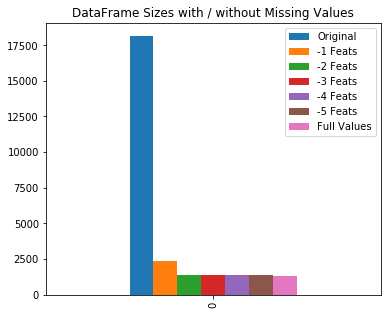

In [7]:
df_comp = pd.DataFrame( [dfSizes], columns=columnNames ) 
df_comp.plot.bar(width=0.5, figsize=(6,5), title="DataFrame Sizes with / without Missing Values")
plt.show()

### Approach 2: Drop the Features

From the previous brief analysis, if we drop _all_ rows that have at least one missing value, then we are removing _a lot_ of information! We see, for instance, that the "NUMCHLD" feature has plenty of missing values and results in a significant reduction of our dataset.

Here's an alternative that preserves more information in this situation. Instead of droping the _rows_ that have an empty value, we can simply drop the column that has the missing data. It will remove a lot less information.

We will _still_ lose _some_ information, but not as much as before. Let's see.

In [8]:
# Drop the feature NUMCHLD
no_numchld_df = train_df.drop( ['NUMCHLD'], axis=1 )

In [9]:
# Generate a copy to work with
df_copy = no_numchld_df.copy()

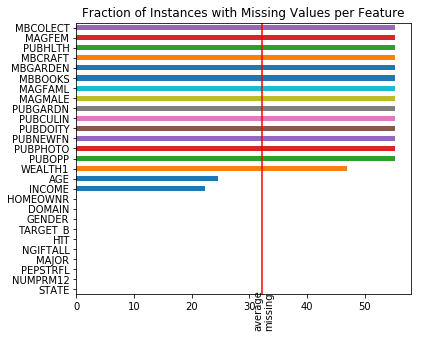

In [10]:
# Find the percentage of missing values for each column in the new dataframe (without the NUMCHLD feature)
empty_fractions = 100.0 * (df_copy.isnull().sum() / len(df_copy))
empty_fractions.sort_values(ascending=True).plot(kind="barh", figsize=(6,5))

average_overall = empty_fractions.mean()
plt.axvline(x=average_overall, color='red')  # Plots a vertical line at x = <value>
plt.text(average_overall - 1.5, -2, 'average\nmissing', rotation=90)  # Set the text for the tick

plt.title("Fraction of Instances with Missing Values per Feature")
plt.show()

In [11]:
dfSizes = [ len(train_df), len(df_copy) ]
columnNames = [ 'Original', 'No NUMCHLD' ]

# Iterate over the top-5 features with the most missing values and drop any row that contains them
for featName in empty_fractions.sort_values(ascending=False).head().index:

    # The subset parameter allows us to check in specific features
    df_copy = df_copy.dropna( subset=[featName], axis=0 )

    dfSizes.append(len(df_copy))
    columnNames.append( '-%d Feats' % (len(dfSizes)-2) )

# In the end, append the size of the dataframe where we have dropped everything
dfSizes.append( len(df_copy.dropna(axis=0)) )
columnNames.append( 'Full Values' )

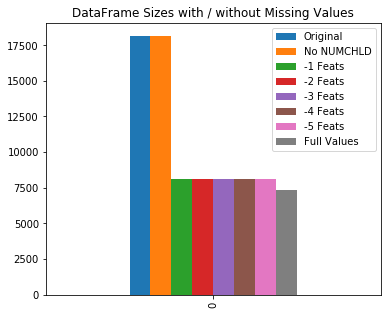

In [12]:
df_comp = pd.DataFrame( [dfSizes], columns=columnNames ) 
df_comp.plot.bar(width=0.5, figsize=(6,5), title="DataFrame Sizes with / without Missing Values")
plt.show()

Not ideal, but still better than the previous case!

Notice that if we now remove the _rows_ that have missing data, we end up with just shy of 7500 instances, much better compared to the ~1200-1300 instances of the previous case.

We could keep doing the same thing with the other columns, removing one of them at a time.

#### Let's compare the two models

Since our goal is to predict new instances, we would like to know how each approach performs as part of a training procedure.

Here's what we will do:

1. We will use the _original_ data frame and drop all the instances that have at least one missing value. We will then train a model on the remaining data.

1. We will use the data frame where we have first dropped the NUMCHLD feature. Following this step, we will drop all instances that have at least one missing value. We will build our classifier on the remaining data.


Let's see the first dataframe

In [13]:

# Dataframe 1: drop all instances with missing values
listwise_delete_df = train_df.dropna()

# Get the features of this 
listDelFeats = listwise_delete_df.drop( ['TARGET_B'], axis=1 )
listDelLabels = listwise_delete_df[['TARGET_B' ]]

listDelFeats = pd.get_dummies(listDelFeats)

logReg = LogisticRegression(C=1, solver='lbfgs')
listDelAvgPrec = np.mean(cross_val_score(logReg, listDelFeats, listDelLabels, scoring='roc_auc', cv=10))
print(listDelAvgPrec)

0.5580277618199576


Let's see the second dataframe

In [14]:

# Dataframe 2: drop all instances with missing values
no_feat_numchld = train_df.drop( ['NUMCHLD'], axis=1 ).dropna()

# Get the features of this 
noNumChldFeats = no_feat_numchld.drop( ['TARGET_B'], axis=1 )
noNumChldLabels = no_feat_numchld[['TARGET_B' ]]

noNumChldFeats = pd.get_dummies(noNumChldFeats)

logReg = LogisticRegression(C=1, solver='lbfgs')
noNumChldAvgPrec = np.mean(cross_val_score(logReg, noNumChldFeats, noNumChldLabels, scoring='roc_auc', cv=10))
print(noNumChldAvgPrec)

0.5849937991479333


### Approach 3: Impute with a constant value

Another popular and very simple approach to address the issue is to impute with a 

In [15]:

# Dataframe 3: drop all instances with missing values
zeroValuedDf = train_df.fillna( 0 )

# Get the features of this 
zeroValuedFeats = zeroValuedDf.drop( ['TARGET_B'], axis=1 )
zeroValuedLabels = zeroValuedDf[['TARGET_B' ]]

zeroValuedFeats = pd.get_dummies(zeroValuedFeats)

logReg = LogisticRegression(C=1, solver='lbfgs')
zeroValuedAvgPrec = np.mean(cross_val_score(logReg, zeroValuedFeats, zeroValuedLabels, scoring='roc_auc', cv=10))
print(zeroValuedAvgPrec)

0.5877380609399924


### Approach 4: Impute with the average value of the dataframe

A slightly better approach compared to the previous one is to use a more "data driven" value. Instead of arbitrarily imputing missing values with zeros, we can impute missing values with the _average value_ of each column.

In [16]:

# Your code here for imputation


# Remember to evaluate your model!


### Approach 5: Masking the missing value

An even more involved approach is to create a _new feature_ that will tell us if the original value is missing or not (binary feature). We can then impute the missing value with one of the previous approaches.

In [17]:

# Your code here for imputation


# Remember to evaluate your model!
